# LAB | Random Forests

### Instructions

- Apply the Random Forests algorithm but this time only by upscaling the data to deal with the imbalance.
- Use Feature Selections that you have learned in class to decide if you want to use all of the features (Variance Threshold, RFE, PCA, etc.)
- Re-run the Random Forest algorithm to determine if the Feature Selection has improved the results.
- Discuss the output and its impact in the business scenario. Is the cost of a false positive equals to the cost of the false negative? How would you change your algorithm or data in order to maximize the return of the business?

In [1]:
# import libraries 
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# import files 
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
target = pd.read_csv('files_for_lab/target.csv')

In [3]:
# confirm no nans present
numerical.isna().sum().sum()
target.isna().sum().sum()
categorical.isna().sum().sum()

0

In [4]:
# x-y split
X = pd.concat([numerical, categorical], axis = 1)
y = target['TARGET_B']

In [5]:
# train-test split before upsampling
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

In [17]:
# onehotencode catgs
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

In [18]:
# scale numericals
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

In [19]:
# concat trains and tests
X_train_treated = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [20]:
# upsampling 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

from sklearn.utils import resample
yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

In [21]:
print(no_donate.shape)
print(yes_donate_oversampled.shape)
print(oversampled.shape)

(72486, 355)
(72486, 355)
(144972, 355)


In [22]:
X_train_oversampled = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled = oversampled['TARGET_B']

In [26]:
# build random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                            min_samples_split=20, # amount of rows still considered at every question
                            min_samples_leaf =20, # ultimate answer based on at least this many rows
                            #max_samples=0.8, #   as we're already giving it samples
                            random_state=42)
# fit the classifier
clf.fit(X_train_oversampled, y_train_oversampled)

# print scores
print(clf.score(X_train_oversampled, y_train_oversampled))
print(clf.score(X_test_treated, y_test))

y_pred = clf.predict(X_test_treated)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.6217476478216483
0.606980034585757


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[11037,  7046],
       [  454,   546]])

In [82]:
# get the cross validation score from this model
from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )
cross_val_scores = cross_val_score(clf, X_train_oversampled, y_train_oversampled, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.624623046042357
[0.62631472 0.6239123  0.6153322  0.61853419 0.62697284 0.62350706
 0.62479719 0.63436301 0.62306697 0.62943   ]


In [30]:
# feature selection
# variance threshold
from sklearn.preprocessing import MinMaxScaler
var_scaler = MinMaxScaler()
numerical_scaled = var_scaler.fit_transform(numerical)

from sklearn.feature_selection import VarianceThreshold  
sel = VarianceThreshold(threshold=0.02)

# fit threshold to drop cols lower than this
sel = sel.fit(numerical_scaled)

In [33]:
# check cols with low variance
num_variance_transform = sel.transform(numerical_scaled)
low_var_cols = list(sel.get_support())

# use list above to drop 
col_list=[col[0] for col in zip(numerical.columns, low_var_cols) if col[1] == True]
len(col_list)
num_post_variance = pd.DataFrame(sel.transform(numerical_scaled), columns = col_list)
num_post_variance.shape

(95412, 79)

In [41]:
# drop cols with high corr with each other
corr_matrix = num_post_variance.corr()

def high_corr(matrix):
    highly_corr=pd.DataFrame()
    
    for col in matrix.columns:
        correlated_cols = matrix[(abs(matrix[col]) >= 0.95)].index   
        correlated_pairs = pd.DataFrame({'Column 1': col, 'Column 2': correlated_cols})  
        highly_corr = pd.concat([highly_corr, correlated_pairs], ignore_index=True)
    highly_corr = highly_corr[highly_corr['Column 1'] < highly_corr['Column 2']]    
    return highly_corr
high_corr(corr_matrix)

,Column 1,Column 2
13,DW1,DW2
17,DW4,DW5
20,DW5,DW6
23,DW6,HUPA2
25,HV1,HV2
61,LFC2,LFC4


In [42]:
# drop cols from corr
drop_corr_list = ['DW2','DW5','DW6','HV2','LFC4']
num_post_var_corr = num_post_variance.drop(drop_corr_list, axis=1)
num_post_var_corr.shape

(95412, 74)

In [80]:
# RFE
X = num_post_var_corr
y = target['TARGET_B']

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
rfe = RFE(LR, n_features_to_select=20, verbose=False)
rfe.fit(X, y)

/Users/valgz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/valgz/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

RFE(estimator=LogisticRegression(), n_features_to_select=20, verbose=False)

In [64]:
# After we run the algorithm, it labels the top features as 1 and the rest are marked in an increasing order of importance.
df = pd.DataFrame(data = rfe.ranking_, columns=['Rank'])
df['Column_name'] = pd.DataFrame(num_post_var_corr).columns
ranking = df[df['Rank']==1]
ranking

,Rank,Column_name
1,1,INCOME
9,1,ETH1
11,1,HHN3
12,1,DW1
14,1,HV1
17,1,HU1
23,1,ETHC2
29,1,HVP6
32,1,HUPA3
34,1,RP1


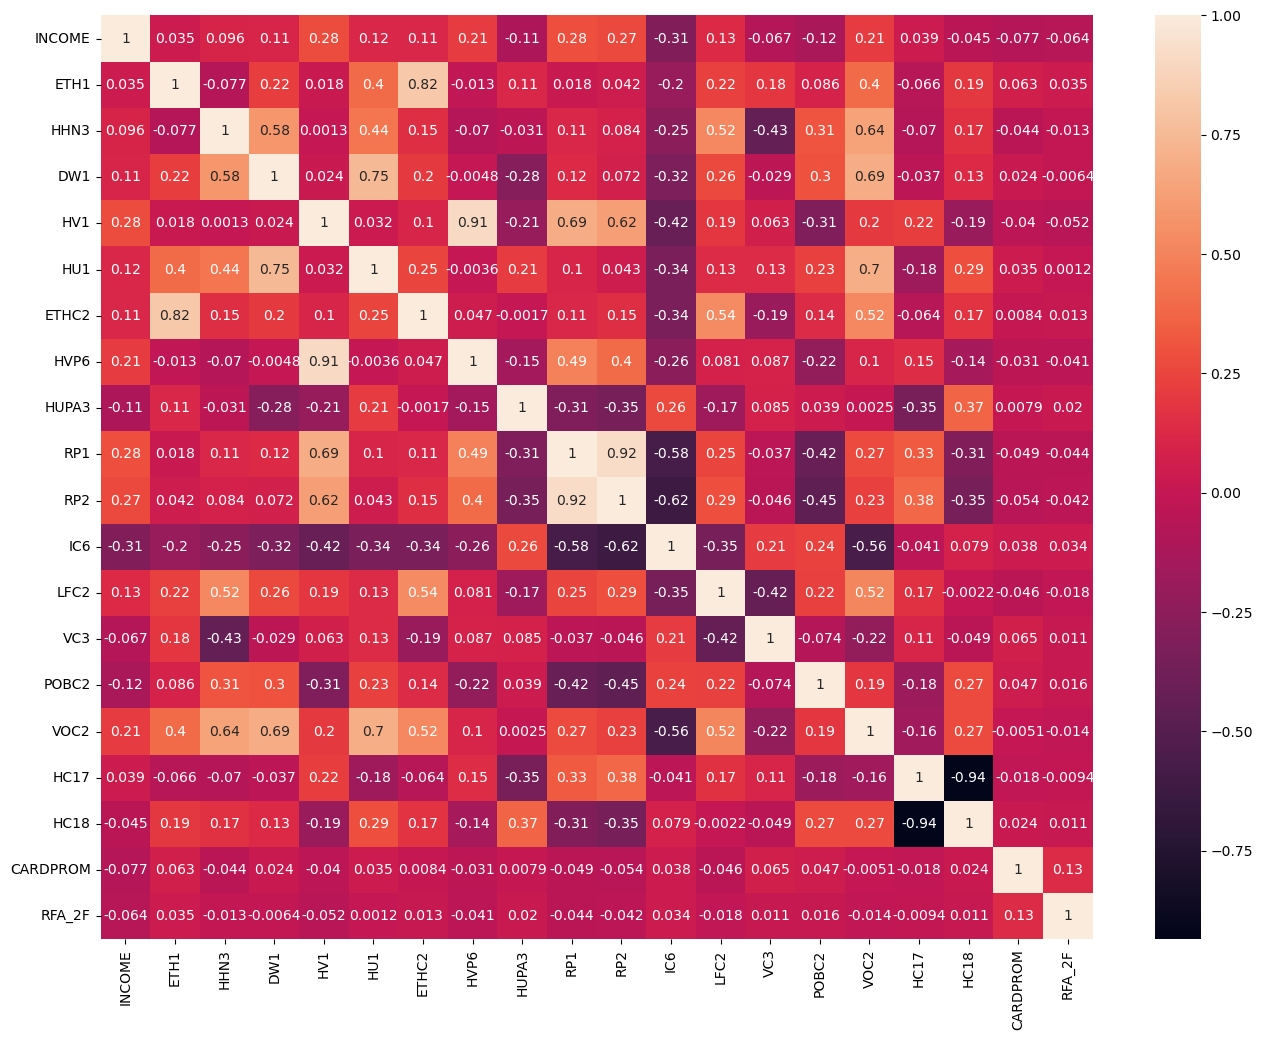

In [65]:
# check corr after rfe to see if they are too related between e/o
import matplotlib.pyplot as plt
import seaborn as sns

ranking_corr = num_post_var_corr[df[df['Rank']==1]['Column_name']].corr(method='pearson') #default
fig, ax= plt.subplots(figsize=(16,12))
sns.heatmap(ranking_corr, annot=True)
plt.show()

In [70]:
# h17, hvp6, RP2 - dropping cols with either too high corr ( > 0.9)
drop_corr_list2 = ['HVP6', 'RP2']

# setting up ranking cols as the ones for our final numerical dataset
# support_ works similarly to varthresh get_support to know which cols are meeting the params
ranking_cols = num_post_var_corr.columns[rfe.support_]
num_post_featselect = num_post_var_corr[ranking_cols]
num_post_featselect.drop(drop_corr_list2, axis=1, inplace=True)
num_post_featselect.shape

/var/folders/nn/t4c1n2z11_g_hd91q77nxzb80000gn/T/ipykernel_44584/503580490.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  num_post_featselect.drop(['HVP6', 'RP2'], axis=1, inplace=True)


(95412, 18)

In [61]:
# # kbest
# X = num_train_scaled
# y = y_train

# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
# kbest = SelectKBest(chi2, k=10).fit_transform(X, y)

# selected = pd.DataFrame(kbest)
# selected.head()

# # To check kbest scores
# model = SelectKBest(chi2, k=10).fit(X, y)
# df = pd.DataFrame(data = model.scores_, columns = ['score'])
# df['Column'] = numX_train.columns
# print(df.sort_values(by = ['score'], ascending = False).head(10))

# cols = df.sort_values(by = ['score'], ascending = False).head(30)['Column']
# len(cols)

In [71]:
# concat final numerical with catg
X = pd.concat([num_post_featselect, categorical], axis=1)

# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

numX_train = X_train.select_dtypes(np.number)
numX_test = X_test.select_dtypes(np.number)
catX_train = X_train.select_dtypes(object) 
catX_test = X_test.select_dtypes(object) 

In [72]:
# encoding categorical
encoder = OneHotEncoder(drop='first').fit(catX_train)
cat_train_enconded = encoder.transform(catX_train).toarray()
cat_train_enconded = pd.DataFrame(cat_train_enconded, columns=encoder.get_feature_names_out()) 
cat_test_enconded = encoder.transform(catX_test).toarray()
cat_test_enconded = pd.DataFrame(cat_test_enconded, columns=encoder.get_feature_names_out())

In [73]:
# scale numericals
from sklearn.preprocessing import MinMaxScaler
transformer = MinMaxScaler().fit(numX_train)
num_train_scaled = transformer.transform(numX_train)
num_train_scaled = pd.DataFrame(num_train_scaled, columns=numX_train.columns)
num_test_scaled  = transformer.transform(numX_test)
num_test_scaled  = pd.DataFrame(num_test_scaled, columns=numX_train.columns)

In [74]:
# concat trains and tests
X_train_treated = pd.concat([num_train_scaled, cat_train_enconded], axis = 1)
X_test_treated  = pd.concat([num_test_scaled, cat_test_enconded],  axis = 1)

In [75]:
# oversample 
# concat train x and y temporarily, remember to reset index on y train
sample_train = pd.concat([X_train_treated, y_train.reset_index(drop=True)], axis=1)

yes_donate = sample_train[sample_train['TARGET_B']==1]
no_donate = sample_train[sample_train['TARGET_B']==0]

from sklearn.utils import resample
yes_donate_oversampled = resample(yes_donate, 
                                replace=True,
                                n_samples = len(no_donate),
                                random_state=0)

oversampled = pd.concat([yes_donate_oversampled, no_donate], axis=0)
oversampled = oversampled.sample(frac=1)

In [76]:
X_train_oversampled = oversampled.drop(['TARGET_B'], axis = 1)
y_train_oversampled = oversampled['TARGET_B']

In [77]:
# build random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5, # max number of questions to ask
                            min_samples_split=20, # amount of rows still considered at every question
                            min_samples_leaf =20, # ultimate answer based on at least this many rows
                            #max_samples=0.8, #   as we're already giving it samples
                            random_state=42)
# fit the classifier
clf.fit(X_train_oversampled, y_train_oversampled)

# print scores
print(clf.score(X_train_oversampled, y_train_oversampled))
print(clf.score(X_test_treated, y_test))

y_pred = clf.predict(X_test_treated)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))

0.6220994398918411
0.605198344075879


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[10993,  7090],
       [  444,   556]])

We have not improved in getting less false negatives (true donors predicted as false ones upped to 444), and false positives (false donors predicted as true donors upped to 7090). 

In [83]:
# get the cross validation score from this model

from sklearn.model_selection import cross_val_score
clf = RandomForestClassifier(max_depth=5,
                            min_samples_split=20,
                            min_samples_leaf =20,
                            # max_samples=0.8 # default val is 1, wwhich means we use 100% of all vals
                            )

cross_val_scores = cross_val_score(clf, X_train_oversampled, y_train_oversampled, cv=10, scoring='f1')
# we build 10 random classifiers, and each one has 100 trees 
print(np.mean(cross_val_scores))
print(cross_val_scores)

0.6239815730774153
[0.62507596 0.62155077 0.61690733 0.62541332 0.62551216 0.62448175
 0.62200109 0.62988162 0.62577271 0.62321903]
